In [1]:
exec(open("init_notebook.py").read())

current working dirC:\Users\abjaw\Documents\GitHub\junction-art


In [2]:
import pyodrx, extensions
from library.Configuration import Configuration
import numpy as np
from junctions.RoadBuilder import RoadBuilder
from junctions.JunctionBuilder import JunctionBuilder
from junctions.AngleCurvatureMap import AngleCurvatureMap
import math
from scipy.spatial import distance

In [3]:
roadBuilder = RoadBuilder()
junctionBuilder = JunctionBuilder()
configuration = Configuration()
angleCurvatureMap = AngleCurvatureMap()
esminiPath = configuration.get("esminipath")

{'test': 'This is nothing', 'test2': {'test22': 'this is something'}, 'esminipath': 'C:\\Users\\abjaw\\Documents\\GitHub\\esmini', 'rootPath': 'C:\\Users\\abjaw\\Documents\\GitHub\\junction-art'}


starting adjustment. May freeze!!!!!!!!!!!!!
start points starting
C:\Users\abjaw\Documents\GitHub\esmini\bin\odrplot.exe C:/Users/abjaw/Documents/GitHub/esmini/bin/pythonroad.xodr


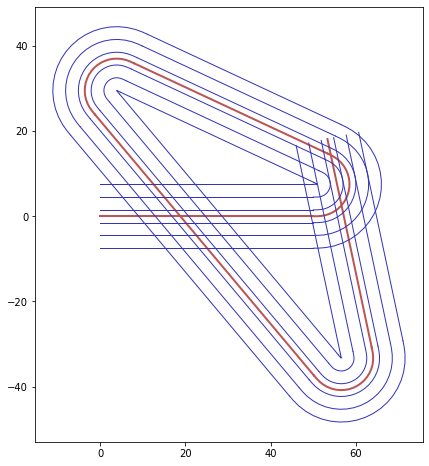

In [4]:
#creating roads


angle = 25
numberofLanes = 3
laneOffset = 3
curve, angle = angleCurvatureMap.getCurvatureForNonOverlappingRoads(angle, numberofLanes, laneOffset)
roads = []
roads.append(pyodrx.create_straight_road(0, 50,  n_lanes=numberofLanes, lane_offset=laneOffset))
roads.append(roadBuilder.createSimpleCurveWithLongArcWithLaneNumberandOffset(1, angle, False, curvature = curve, _n_lanes = numberofLanes, _lane_offset=laneOffset))
roads.append(pyodrx.create_straight_road(2, 50, n_lanes=numberofLanes, lane_offset=laneOffset))
roads.append(roadBuilder.createSimpleCurveWithLongArcWithLaneNumberandOffset(3, angle, False, curvature = curve, _n_lanes = numberofLanes, _lane_offset=laneOffset))
roads.append(pyodrx.create_straight_road(4, 80, n_lanes=numberofLanes, lane_offset=laneOffset))
roads.append(roadBuilder.createSimpleCurveWithLongArcWithLaneNumberandOffset(5, angle + 0.0174533 * 3, False, curvature = curve, _n_lanes = numberofLanes, _lane_offset=laneOffset))
roads.append(pyodrx.create_straight_road(6, 50, n_lanes=numberofLanes, lane_offset=laneOffset))


roads[0].add_successor(pyodrx.ElementType.road,1,pyodrx.ContactPoint.start)

roads[1].add_predecessor(pyodrx.ElementType.road,0,pyodrx.ContactPoint.end)
roads[1].add_successor(pyodrx.ElementType.road,2,pyodrx.ContactPoint.start)

roads[2].add_predecessor(pyodrx.ElementType.road,1,pyodrx.ContactPoint.end)
roads[2].add_successor(pyodrx.ElementType.road,3,pyodrx.ContactPoint.start)

roads[3].add_predecessor(pyodrx.ElementType.road,2,pyodrx.ContactPoint.end)
roads[3].add_successor(pyodrx.ElementType.road,4,pyodrx.ContactPoint.start)

roads[4].add_predecessor(pyodrx.ElementType.road,3,pyodrx.ContactPoint.end)
roads[4].add_successor(pyodrx.ElementType.road,5,pyodrx.ContactPoint.start)

roads[5].add_predecessor(pyodrx.ElementType.road,4,pyodrx.ContactPoint.end)
roads[5].add_successor(pyodrx.ElementType.road,6,pyodrx.ContactPoint.start)

roads[6].add_predecessor(pyodrx.ElementType.road,5,pyodrx.ContactPoint.end)

odrName = "curve_test"

odr = extensions.createOdr(odrName, roads, [])
extensions.view_road(odr, esminiPath)

In [ ]:
roads[1].curveType


In [ ]:
findCollidingRoadDict(odr.roads)

In [ ]:
odr.roads.get('6').getAdjustedStartPosition()


In [6]:
def perp(a):
    b = np.empty_like(a)
    b[0] = -a[1]
    b[1] = a[0]
    return b

def seg_intersect(a1,a2, b1,b2):
    da = [a2[0]-a1[0], a2[1]-a1[1]]
    db = [b2[0]-b1[0], b2[1]-b1[1]]
    dp = [a1[0]-b1[0], a1[1]-b1[1]]
    dap = perp(da)
    denom = np.dot( dap, db)
    num = np.dot( dap, dp )
    return (num / denom.astype(float))*db[0] + b1[0], (num / denom.astype(float))*db[1] + b1[1]

def isCollidingRoad(road1, road2):
    p1, p2, p3, p4 = [[], []], [[], []], [[], []], [[], []] 
    p1[0], p1[1], _ = road1.getAdjustedStartPosition()
    p2[0], p2[1], _ = road1.getAdjustedEndPosition()
    
    p3[0], p3[1], _ = road2.getAdjustedStartPosition()
    p4[0], p4[1], _ = road2.getAdjustedEndPosition()
    
    intersection = seg_intersect(p1,p2,p3,p4) 
    
    segmentLength_r1 = distance.euclidean(p1, p2)
    distanceIntersectionandStart_r1 = distance.euclidean(intersection, p1)
    distanceIntersectionandEnd_r1 = distance.euclidean(intersection, p2)
    
    segmentLength_r2 = distance.euclidean(p3, p4)
    distanceIntersectionandStart_r2 = distance.euclidean(intersection, p3)
    distanceIntersectionandEnd_r2 = distance.euclidean(intersection, p4)
    
#     print(segmentLength_r1, distanceIntersectionandStart_r1, distanceIntersectionandEnd_r1)
#     print(segmentLength_r2, distanceIntersectionandStart_r2, distanceIntersectionandEnd_r2)
    
    if(
        (round((distanceIntersectionandEnd_r1 + distanceIntersectionandStart_r1), 2) == round(segmentLength_r1, 2))
        and (round((distanceIntersectionandEnd_r2 + distanceIntersectionandStart_r2), 2) == round(segmentLength_r2, 2))
    ):
        if (distanceIntersectionandEnd_r1 == 0 and distanceIntersectionandStart_r2 == 0):
            return None
        return intersection
    else:
        return None  
    
def findCollidingRoadDict(roads):
    collidingRoadDict = {}
    for r1 in range(0, len(roads) - 1):
        for r2 in range(r1, len(roads)):
            if r1 != r2:
                r1 = str(r1)
                r2 = str(r2)
                intersection = isCollidingRoad(roads.get(r1), roads.get(r2))
                if intersection is not None:
                    collidingRoadDict.update({(r1, r2): intersection})
#                     print(r1, r2)
    return collidingRoadDict


In [7]:
findCollidingRoadDict(odr.roads)

{('0', '4'): (18.802776954886365, 0.0),
 ('1', '6'): (54.14008406411122, 14.317050859477174)}

In [ ]:
print(isCollidingRoad(odr.roads.get('1'),odr.roads.get('6')))

In [ ]:
28.776505347250605+21.223494652749395

In [5]:
16.93620517474799+3.0637948252520126

20.000000000000004